# Notebook for comparing most central nodes in different time periods

In [1]:
#Import libraries used in notebooks
import pandas as pd
from scipy import stats
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import matplotlib.patches as mpatches

## Import Data

In [47]:
#Loading data
CleanDataAllGoals=pd.read_pickle('CleanDataAllGoals')
#Loading correlation data
CorrelationAllGoals=pd.read_pickle('CorrelationAllGoals')
#Loading Centrality
centOVR=pd.read_pickle('BrazilEigenvectorCentralityAllGoals')
#Loading indicator list
with open(r'/Users/bkemp/Data Science/Project/IndicatorList.ob','rb') as fp:
        IndicatorList= pickle.load(fp)

## Sorting Data

In [3]:
#Split data into first and last 10 year periods (2000-2010 and 2010-2020)
DataFirst10 = CleanDataAllGoals.loc['2000':'2010',:]
DataLast10 = CleanDataAllGoals.loc['2010':'2020',:]
#Perform spearman correlation on separate time periods with min 10 data pairs
CorrelationFirst10 = DataFirst10.corr(method="spearman",min_periods=10)
CorrelationLast10 = DataLast10.corr(method="spearman",min_periods=10)

In [7]:
#Drop any all na rows and columns to save space
#First 10
CorrelationFirst10.dropna(how='all',axis=0,inplace=True)
CorrelationFirst10.dropna(how='all',axis=1,inplace=True)
#Last 10
CorrelationLast10.dropna(how='all',axis=0,inplace=True)
CorrelationLast10.dropna(how='all',axis=1,inplace=True)

## Calculating Eigenvector centrality

In [8]:
#Function to create network and perform eigenvector centrality
def cent(corData):
    
    #Create Empty network Graphs for positive correlation and negative correlation
    Hplus=nx.Graph()
    Hminus=nx.Graph()
    
    #Get correlation matrix values (which with be the edges)
    netval=corData.values
    
    #Get correlation seriescode (which will be the nodes)
    netNode=list(corData.index.get_level_values(2))
        
    #Create positive (Synergy) network from values greater than 0.6
    for m in range(0,len(netNode)):
        for n in range(1+m,len(netNode)):
            if netval[m,n]>0.6:
                Hplus.add_edge(netNode[m],netNode[n],weight=netval[m,n])
   
    #Create Negative (Trade-off) Network from values less than -0.6
    for m in range(0,len(netNode)):
        for n in range(1+m,len(netNode)):
            if netval[m,n]<-0.6:
                Hminus.add_edge(netNode[m],netNode[n],weight=abs(netval[m,n])) #Absolute used as centrality of negative values not well documented
    
    #Perform eigenvector centrality, using weight as edges between nodes (Correlation)
    HplusCen = nx.eigenvector_centrality(Hplus,weight='weight',max_iter=1000,tol=1e-6)
    HminusCen = nx.eigenvector_centrality(Hminus,weight='weight',max_iter=1000,tol=1e-6)
  
    return HplusCen, HminusCen

In [9]:
#Run function for first 10 and last 10
SynEigFirst10, TradeEigFirst10 = cent(CorrelationFirst10)
SynEigLast10, TradeEigLast10 = cent(CorrelationLast10)

### Combining Data

In [10]:
#Combing centrality results
#First 10
SEFirst10=pd.DataFrame(SynEigFirst10.items(),columns=['SeriesCode', 'Synergy Eigenvector Centrality 2000-2010'])
TEFirst10=pd.DataFrame(TradeEigFirst10.items(),columns=['SeriesCode', 'Tradeoff Eigenvector Centrality 2000-2010'])
#Last 10
SELast10=pd.DataFrame(SynEigLast10.items(),columns=['SeriesCode', 'Synergy Eigenvector Centrality 2010-2020'])
TELast10=pd.DataFrame(TradeEigLast10.items(),columns=['SeriesCode', 'Tradeoff Eigenvector Centrality 2010-2020'])
#Combining altogether
EigOVR=pd.merge(SEFirst10,TEFirst10,on='SeriesCode')
EigOVR=pd.merge(EigOVR,SELast10,on='SeriesCode')
EigOVR=pd.merge(EigOVR,TELast10,on='SeriesCode')

In [13]:
#Saving Centrality
EigOVR.to_pickle('BrazilEigenvectorCentralitySplit')

In [14]:
#Loading Centrality
EigOVR=pd.read_pickle('BrazilEigenvectorCentralitySplit')

Combining Overall and Split Eigenvector Centrality

In [48]:
#Combining centrality for global network and for split 10 year netorks
EigenvectorC = pd.merge(EigOVR,centOVR,on='SeriesCode')

In [60]:
#Sort centrality into top 5
EigenvectorC.sort_values('Synergy Eigenvector Centrality',ascending=False).iloc[:5,:]

,SeriesCode,Synergy Eigenvector Centrality 2000-2010,Tradeoff Eigenvector Centrality 2000-2010,Synergy Eigenvector Centrality 2010-2020,Tradeoff Eigenvector Centrality 2010-2020,Synergy Eigenvector Centrality,Tradeoff Eigenvector Centrality
52,EG_EGY_RNEW--,0.111570,0.078962,0.137926,0.098766,0.064757,0.046528
23,SH_DYN_MORTN--<5Y_FEMALE_,0.110221,0.078962,0.130876,0.090953,0.065666,0.046895
64,IT_NET_BBNDN--ANYS_,0.110221,0.078962,0.135399,0.098766,0.064473,0.046528
21,SH_DYN_MORT--<5Y_FEMALE_,0.110221,0.078962,0.130876,0.090953,0.065666,0.046895
22,SH_DYN_MORTN--<5Y_MALE_,0.110221,0.078962,0.135105,0.097523,0.065186,0.046768


### Changes in Synergy

Want to know indicators overall rank in eigenvector centrality and then its rank for the first 10 years and last 10 years

In [63]:
#Enter Full SeriesCode (with disaggregators) that you want the position for
EigenvectorIndicator = input('Type Indicator SeriesCode: ')
#Set length for number of indicators in list
indEig = pd.Series(range(1,len(EigenvectorC)+1))

#Order dataframe by overall synergy eigenvector centrality then set index so that first value equals 1, second equals 2 etc
TopSyn=EigenvectorC.sort_values('Synergy Eigenvector Centrality',ascending=False).set_index(indEig).copy()
#Get the position of the series code entered before in this ordered dataframe and extract index which will give its position
SynPositionOVR=TopSyn.SeriesCode[TopSyn.SeriesCode==EigenvectorIndicator].index.values

#Order dataframe by synergy eigenvector centrality for first 10 years and set index
TopSynFirst10=EigenvectorC.sort_values('Synergy Eigenvector Centrality 2000-2010',ascending=False).set_index(indEig).copy()
#Get position of series code entered in this ordered dataframe and extract index for position
SynPositionFirst10=TopSynFirst10.SeriesCode[TopSynFirst10.SeriesCode==EigenvectorIndicator].index.values

#Order dataframe by synergy eigenvector centrality for last 10 years and set index
TopSynLast10=EigenvectorC.sort_values('Synergy Eigenvector Centrality 2010-2020',ascending=False).set_index(indEig).copy()
#Get position of series code entered in this ordered dataframe and extract index for position
SynPositionLast10=TopSynLast10.SeriesCode[TopSynLast10.SeriesCode==EigenvectorIndicator].index.values

#Print positions extracted
print(('Position Overall:',SynPositionOVR),('Position 2000-2010',SynPositionFirst10),('Position 2010-2020',SynPositionLast10))

Type Indicator SeriesCode: IT_NET_BBNDN--ANYS_
('Position Overall:', array([25])) ('Position 2000-2010', array([3])) ('Position 2010-2020', array([15]))


In [58]:
#List for top 5 indicators and their positions where [position first 10, position last 10] and Num1 is top synergy eigenvector centrality indicator
Num1 = [37,52] #EG_EGY_CLEAN--
Num2 = [20,33] #SH_DYN_IMRTN--<1Y_BOTHSEX_
Num3 = [31,34] #SH_DYN_IMRTN--<1Y_FEMALE_
Num4 = [7,30] #SH_DYN_MORTN--<5Y_BOTHSEX_
Num5 = [2,31] #SH_DYN_MORTN--<5Y_FEMALE_
Name1 = 'EG_EGY_CLEAN--'
Name2 = 'SH_DYN_IMRTN--<1Y_BOTHSEX_'
Name3 = 'SH_DYN_IMRTN--<1Y_FEMALE_'
Name4 = 'SH_DYN_MORTN--<5Y_BOTHSEX_'
Name5 = 'SH_DYN_MORTN--<5Y_FEMALE_'

/var/folders/5h/nl7cgmvx6cv0_q4zj9wkhhg00000gn/T/ipykernel_18164/1965837570.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['2000-2010','','','','','2010-2020'])


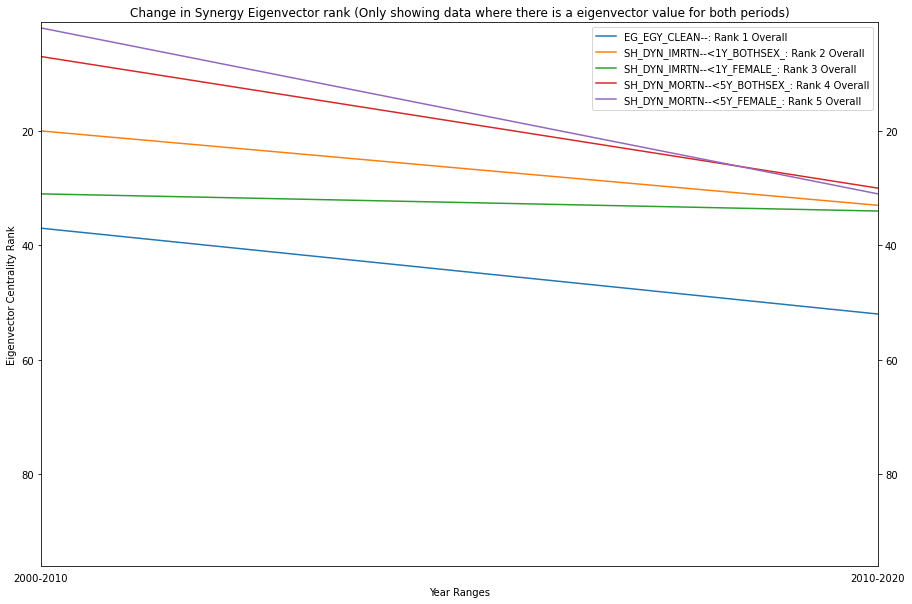

In [65]:
#Plot changes in indicators over the two periods
fig,ax = plt.subplots(1,figsize=(15,10))
#Plot all 5 indicator positions
ax.plot(Num1)
ax.plot(Num2)
ax.plot(Num3)
ax.plot(Num4)
ax.plot(Num5)
#Plot legend adding names of indicators
plt.legend([Name1+': Rank 1 Overall',Name2+': Rank 2 Overall',Name3+': Rank 3 Overall',Name4+': Rank 4 Overall',Name5+': Rank 5 Overall'])
plt.title('Change in Synergy Eigenvector rank (Only showing data where there is a eigenvector value for both periods)')
#Set axis ticks to show two time periods
ax.set_xticklabels(['2000-2010','','','','','2010-2020'])
#Show axis labels on right so its easier to measure changes
ax.tick_params(labelright=True,right=True,bottom=False)
plt.xlabel('Year Ranges')
plt.ylabel('Eigenvector Centrality Rank')
plt.xlim([0,1])
plt.ylim([1,96])
#Invert y axis so rank 1 is at the top and the lowest rank is at the bottom
plt.gca().invert_yaxis()
plt.show()

### Changes in Tradeoff

In [29]:
#Enter Full SeriesCode (with disaggregators) that you want the position for
EigenvectorIndicator = input('Type Indicator SeriesCode: ')
#Set length for number of indicators in list
indEig = pd.Series(range(1,len(EigenvectorC)+1))

#Order dataframe by overall tradeoff eigenvector centrality then set index so that first value equals 1, second equals 2 etc
TopTrade=EigenvectorC.sort_values('Tradeoff Eigenvector Centrality',ascending=False).set_index(indEig).copy()
#Get the position of the series code entered before in this ordered dataframe and extract index which will give its position
TradePositionOVR=TopTrade.SeriesCode[TopTrade.SeriesCode==EigenvectorIndicator].index.values

#Order dataframe by tradeoff eigenvector centrality for first 10 years and set index
TopTradeFirst10=EigenvectorC.sort_values('Tradeoff Eigenvector Centrality 2000-2010',ascending=False).set_index(indEig).copy()
#Get position of series code entered in this ordered dataframe and extract index for position
TradePositionFirst10=TopTradeFirst10.SeriesCode[TopTradeFirst10.SeriesCode==EigenvectorIndicator].index.values

#Order dataframe by synergy eigenvector centrality for last 10 years and set index
TopTradeLast10=EigenvectorC.sort_values('Tradeoff Eigenvector Centrality 2010-2020',ascending=False).set_index(indEig).copy()
#Get position of series code entered in this ordered dataframe and extract index for position
TradePositionLast10=TopTradeLast10.SeriesCode[TopTradeLast10.SeriesCode==EigenvectorIndicator].index.values

#Print positions extracted
print(('Position Overall:',TradePositionOVR),('Position 2000-2010',TradePositionFirst10),('Position 2010-2020',TradePositionLast10))

Type Indicator SeriesCode: SH_STA_ANEM--15-49_FEMALE_
('Position Overall:', array([5])) ('Position 2000-2010', array([29])) ('Position 2010-2020', array([22]))


In [30]:
#List for top 5 indicators and their positions where [position first 10, position last 10] and TNum1 is top tradeoff eigenvector centrality indicator
TNum1 = [1,1] #ER_RSK_LST--
TNum2 = [2,10] #SH_HIV_INCD--ALLAGE_FEMALE_
TNum3 = [81,5] #NV_IND_MANF--ISIC4_C_
TNum4 = [17,31] #SP_ACS_BSRVH2O--RURAL_
TNum5 = [29,22] #SH_STA_ANEM--15-49_FEMALE_
TName1 = 'ER_RSK_LST--'
TName2 = 'SH_HIV_INCD--ALLAGE_FEMALE_'
TName3 = 'NV_IND_MANF--ISIC4_C_'
TName4 = 'SP_ACS_BSRVH2O--RURAL_'
TName5 = 'SH_STA_ANEM--15-49_FEMALE_'

/var/folders/5h/nl7cgmvx6cv0_q4zj9wkhhg00000gn/T/ipykernel_18164/2188068067.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['2000-2010','','','','','2010-2020'])


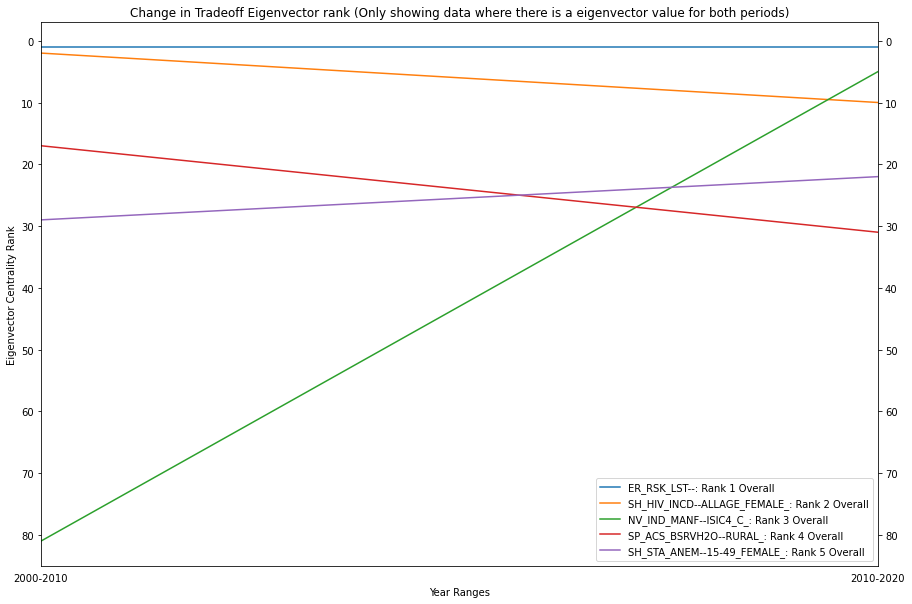

In [31]:
#Plot changes in indicators over the two periods
fig,ax = plt.subplots(1,figsize=(15,10))
#Plot all 5 indicator positions
ax.plot(TNum1)
ax.plot(TNum2)
ax.plot(TNum3)
ax.plot(TNum4)
ax.plot(TNum5)
#Plot legend adding names of indicators
plt.legend([TName1+': Rank 1 Overall',TName2+': Rank 2 Overall',TName3+': Rank 3 Overall',TName4+': Rank 4 Overall',TName5+': Rank 5 Overall'])
plt.title('Change in Tradeoff Eigenvector rank (Only showing data where there is a eigenvector value for both periods)')
#Set axis ticks to show two time periods
ax.set_xticklabels(['2000-2010','','','','','2010-2020'])
#Show axis labels on right so its easier to measure changes
ax.tick_params(labelright=True,right=True,bottom=False)
plt.xlabel('Year Ranges')
plt.ylabel('Eigenvector Centrality Rank')
plt.xlim([0,1])
#Invert y axis so rank 1 is at the top and the lowest rank is at the bottom
plt.gca().invert_yaxis()
plt.show()